# Linear regression
Superconducting database from UCI website. 

21263 samples (materials that superconduct). 

Features: the number of atoms of each element; 81 properties like weighted atomic mass, weighted first ionization energy of atoms, etc.

Target: critical temperature.

# 1. Import data 

In [620]:
import pandas as pd
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

# the number of different atoms
df = pd.read_csv('https://raw.githubusercontent.com/AlexUCAS/ML_SC_LR/main/unique_m.csv')  
df.drop(columns=['critical_temp', 'material'], inplace=True)
df = df.loc[:, (df != 0).any(axis=0)]  # drop columns that only have zero
# physical quantities
df1 = pd.read_csv('https://raw.githubusercontent.com/AlexUCAS/ML_SC_LR/main/train.csv')
columns = df1.columns
df = pd.concat([df, df1], axis=1)
print(df.shape)
df.head()

(21263, 159)


,H,Li,Be,B,C,N,O,F,Na,Mg,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


# 2. Preprocessing features

In [621]:
print(df.shape)
# Delete features that have little correlation with the target.(|correlation| < 0.2)
correlationWithTarget = df.corr().iloc[:, -1:]
correlationWithTarget = correlationWithTarget.loc[correlationWithTarget['critical_temp'].abs() >= 0.2]  
index = correlationWithTarget.index
df = df[index]
print(df.shape)

(21263, 159)
(21263, 74)


In [622]:
# pick out features highly correlated; keep independent features as least as possible
correlationMatrix = df.corr()
# build a dataframe 'a': index is features, the 1st and 2nd column is the list of correlated features 
# and the number of correlated features 
a = pd.Series(dtype='float64')  # the list of correlated features 
b = pd.Series(dtype='float64')  # the number of correlated features
for feature in df.columns[:-1]:
  a[feature] = correlationMatrix[feature].loc[correlationMatrix[feature] > 0.8].index.tolist()
  a[feature].remove(feature)  # remove the feature itself from the list
  b[feature] = len(a[feature])
a = pd.concat([a, b], axis=1).reset_index()  
a.set_index('index', inplace=True)
a.sort_values(1, inplace=True, ascending=False)

a = a[a[1] > 0]  # remove features that have no correlation with the rest
abundant = []  # the features supposed to be removeded among those that have correlation with others
while (a[1] != 0).sum() != 0:
  abundant.append(a.index[-1])
  for higherPoint in a.iloc[-1, 0]:  # considering a graph connecting correlated features 
                                     # where features correlated with more features locate higher
    a.loc[higherPoint, 0].remove(a.index[-1])
    a.loc[higherPoint, 1] = len(a.loc[higherPoint, 0])
  a = a.iloc[:-1, :]
  a = a[a[1] > 0]
  a.sort_values(1, inplace=True, ascending=False)
df.drop(columns=abundant, inplace=True)
print(df.shape)
df.sort_values('critical_temp',  inplace=True, ascending=False)

(21263, 25)


# 3. Linear regression

0.6581830250433212

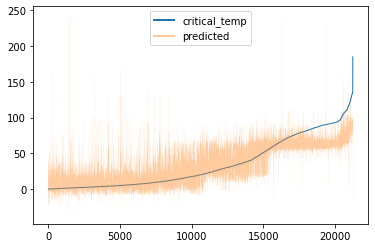

In [623]:
columnNames = df.columns
x = df[columnNames[:-1]]  # features

# scale to [0, 1]
min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(x)

# fit with regularization
model = Ridge(alpha=1)
model.fit(x, df['critical_temp'])
df['predicted'] = model.predict(x)  # add a predicted Tc column
df = df.sort_values('critical_temp').reset_index(drop=True)  # sort with respect to Tc; plot becomes readable after sorting

plt.plot(df.index, df['critical_temp'], linewidth=1, label='critical_temp')
plt.plot(df.index, df['predicted'], linewidth=0.08, label='predicted', alpha=0.4)
leg = plt.legend()
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)
# plt.savefig('plot_2.pdf')

# from google.colab import files
# files.download('plot_2.pdf')

from sklearn.metrics import r2_score

r2_score(df['critical_temp'], df['predicted'])

                               effect
O                                43.3
Ca                               80.3
Cu                               10.7
Sr                               65.1
Y                                26.9
Ba                              220.0
Hg                               81.1
std_atomic_mass                  21.2
wtd_range_fie                   -20.1
entropy_atomic_radius            26.4
wtd_range_atomic_radius         -13.9
wtd_range_Density                 9.7
wtd_std_Density                 -21.3
gmean_ElectronAffinity          -35.0
wtd_std_ElectronAffinity          8.1
wtd_gmean_FusionHeat             20.9
std_FusionHeat                  -11.2
mean_ThermalConductivity         94.9
gmean_ThermalConductivity      -101.0
wtd_range_ThermalConductivity    22.1
std_ThermalConductivity         -10.4
wtd_gmean_Valence               -18.2
wtd_range_Valence                 9.7
std_Valence                     -19.6


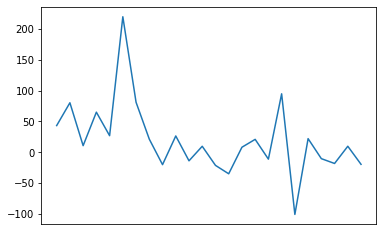

In [624]:
params = pd.Series(model.coef_, index=df[columnNames[:-1]].columns)
plt.plot(params)
plt.xticks([])
print(pd.DataFrame({'effect': params.round(1)}))